In [1]:
# https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import math
from collections import Counter
# import numpy as np
import seaborn as sns
# import pandas as pd
import scipy.stats as ss
# import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output


#Dataframe Visual Settings
pd.set_option('display.max_rows',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',400)

def clean_bank_statement_file(filename):
    """
    Extract, modify & clean bank statement raw file for neater format
    """
    #Cleaning data
    # csv_file = '\Bank Statements\'' + filename
    df = pd.read_csv(filename,
                     usecols=['Transaction Number','Date','Memo','Amount Debit','Amount Credit'],
                     skiprows=3)
    
    df.fillna({'Amount Debit':0, 'Amount Credit':0},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df.sort_values(by=['Date'],ascending=False,ignore_index=True,inplace=True)
    df['Memo'].fillna('Default',inplace=True)
    df['Transaction Number'] = df['Transaction Number'].apply(lambda x: x.split('**')[1])
    df['Purchase Date'] = df[df['Memo'].str.contains('1574 ',na=False)]['Memo']\
        .apply(lambda x: x.split('1574 ')[1])
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'],format = '%m/%d %H:%M')
    df['Purchase Date'] = df['Purchase Date']+pd.DateOffset(years=120)
    df.loc[df['Purchase Date'].isna(),'Purchase Date'] = df['Date'].copy()
    df['Memo'] = df['Memo'].apply(lambda x: x.split('*****')[0])
    df['Content'] = df['Transaction Number'] + ' ' + df['Memo']
    df['Amount'] = df['Amount Debit'].astype(float) + df['Amount Credit'].astype(float)
    df['Category'] = 'Default'
    df.drop(df[df['Content'].str.contains("INTERNET TRANSFER",na=False)].index,inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.drop(['Transaction Number','Memo','Amount Debit','Amount Credit'],
            axis=1,inplace=True)
    df.sort_values(by=['Purchase Date'],ascending=False, inplace=True)
    return df

def categorize(df):
    """
    For common transactions, categorize these early, and use to train a model
    """
    #Easier Categorization
    df.loc[df['Content'].str.contains("UBER EATS",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("HARRIS",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("GIANT",na=False),'Category'] = 'Groceries'
    df.loc[df['Content'].str.contains("USAA",na=False),'Category'] = 'USAA Insurance'
    df.loc[df['Content'].str.contains("Accenture",na=False),'Category'] = 'Pay Check'
    df.loc[df['Content'].str.contains("XSPORT",na=False),'Category'] = 'Gym'
    df.loc[df['Content'].str.contains("DISTRICT MARTIAL ARTS",na=False),'Category'] = 'Gym'
    df.loc[df['Content'].str.contains("PARKING",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    df.loc[df['Content'].str.contains("NAZRET",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("TAJ OF INDIA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("DCPILLAR",na=False),'Category'] = 'Tithe'
    df.loc[df['Content'].str.contains("GOOGLE",na=False),'Category'] = 'Entertainment'
    df.loc[df['Content'].str.contains("VENMO/CASHOUT",na=False),'Category'] = 'Venmo Extra'
    df.loc[df['Content'].str.contains("CITGO",na=False),'Category'] = 'Gas'
    df.loc[df['Content'].str.contains("SHELL",na=False),'Category'] = 'Gas'
    df.loc[df['Content'].str.contains("PUPATELLA",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("GOOD COMPANY DONUT",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("STARBUCKS",na=False),'Category'] = 'Dining Out'
    df.loc[df['Content'].str.contains("UBER TRIP",na=False),'Category'] = 'Tolls/Uber/Metro/Parking'
    df.loc[df['Content'].str.contains("VERIZON",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("WASHINGTON GAS",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("ENERGY",na=False),'Category'] = 'Utilities'
    df.loc[df['Content'].str.contains("TOM COLEMAN",na=False),'Category'] = 'Phone'
    df.loc[df['Content'].str.contains("STDNT LOAN",na=False),'Category'] = 'Student Loans'
    df.loc[(df['Content'].str.contains("VENMO/PAYMENTWALTER COLEMAN Default",na=False)) &
           (df['Amount'] == -668.75 | df['Amount'] == -845),'Category'] = 'Rent'
    df.loc[df['Content'].str.contains("Margaret Coleman",na=False),'Category'] = 'Extra'
    df.loc[df['Content'].str.contains("Person-to-Person TransferPAYPAL",na=False),'Category'] = 'Extra'
    return df 

def create_grand_file(directory):
    """
    Extract based on string file names
    """
    grand_df = pd.DataFrame()
    temp_df = pd.DataFrame()

    #Get list of files
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            temp_df = clean_bank_statement_file(filename)
            temp_df = categorize(temp_df)
            grand_df = pd.concat([grand_df,temp_df],ignore_index=True)
    
    return grand_df

directory = r'C:\Users\waltj\OneDrive\Data Science Self Learning\BankStatementOrganizer'
grand_df = create_grand_file(directory)

In [71]:
import scipy

In [72]:
import stat

In [2]:
grand_df

Date       Purchase Date                                                              Content   Amount                  Category
0   2020-04-29 2020-04-29 12:47:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001    -5.11                 Groceries
1   2020-04-29 2020-04-29 02:32:00  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00                     Extra
2   2020-04-29 2020-04-28 22:44:00   POS PURCHASE Non-PINPP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99             Entertainment
3   2020-04-28 2020-04-28 13:17:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001    -5.11                 Groceries
4   2020-04-27 2020-04-26 22:23:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB600   -21.23                Dining Out
5   2020-04-27 2020-04-26 22:23:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB500    -3.70                Dining Out
6   2020-04-24 2020-04-24 15:16:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001   -47.51                 Groceries
7   2020-04-23 2020-04-23 03:43:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN1610   -17.49                Dining Out
8   2020-04-23 2020-04-23 03:43:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8900    -2.09                Dining Out
9   2020-04-23 2020-04-22 19:30:00    POS PURCHASE Non-PINVTG*Emmaus Family Couns 703-7292822 VA000000   -125.00                   Default
10  2020-04-22 2020-04-22 11:10:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001   -39.52                 Groceries
11  2020-04-22 2020-04-22 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62             Student Loans
12  2020-04-22 2020-04-22 00:00:00                                    USAA.COM PAY EXT/PCWALTER COLEMAN  -243.63            USAA Insurance
13  2020-04-22 2020-04-22 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI  -109.81                     Tithe
14  2020-04-22 2020-04-21 22:45:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN1090    -2.10                Dining Out
15  2020-04-22 2020-04-21 22:45:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8800   -20.99                Dining Out
16  2020-04-21 2020-04-21 01:58:00    POS PURCHASE Non-PINLCA*LABCORP 8008456167 800-845-6167 NCIN7200    -21.82                   Default
17  2020-04-21 2020-04-21 00:00:00                         Accenture Federa/PAYRLL DEPColeman, Walter J  3311.31                 Pay Check
18  2020-04-20 2020-04-20 12:04:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001    -5.41                 Groceries
19  2020-04-20 2020-04-20 00:00:00                                  VENMO/PAYMENTWALTER COLEMAN Default  -668.75                      Rent
20  2020-04-20 2020-04-20 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1410.02             Student Loans
21  2020-04-20 2020-04-20 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI -1200.00                     Tithe
22  2020-04-20 2020-04-19 22:40:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8700   -20.49                Dining Out
23  2020-04-20 2020-04-19 22:40:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN7400    -2.10                Dining Out
24  2020-04-20 2020-04-19 22:40:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN0700    -2.09                Dining Out
25  2020-04-20 2020-04-19 22:40:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN7900   -17.49                Dining Out
26  2020-04-20 2020-04-18 23:38:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN1410   -13.74                Dining Out
27  2020-04-20 2020-04-18 23:38:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN6600    -1.05      

In [3]:
grand_df['Category'].value_counts()

Default                     301
Groceries                   141
Dining Out                  102
Tolls/Uber/Metro/Parking     46
Venmo Extra                  23
Utilities                    21
Pay Check                    19
Gas                          15
Tithe                        15
Entertainment                13
Student Loans                13
Extra                        12
Gym                          12
USAA Insurance               10
Rent                          8
Phone                         6
Name: Category, dtype: int64

In [4]:
grand_df[grand_df['Category'] == 'Default']['Content'].value_counts()

VENMO/PAYMENTWALTER COLEMAN Default                                    28
POS PURCHASE Non-PINTortas y Tacos La Chiqu Arlington VA007885          8
POS PURCHASE Non-PINVTG*Emmaus Family Couns 703-7292822 VA000000        8
ROBINHOOD/FundsWalter Coleman Default                                   6
POS PURCHASE Non-PINCROWNE PLAZA NATIONAL R ARLINGTON VA69              5
WEBULL FINANCIAL/ACHWALTER COLEMAN                                      3
FUNDRISE GROWTH/2025840550WALTER COLEMAN                                3
FUNDRISE/2025840550WALTER COLEMAN                                       3
Mobile Check Deposit Default                                            3
POS PURCHASE Non-PINBRONSON OF ARLINGTON ARLINGTON VA000026             3
POS PURCHASE with PINALDI 71180 BAILEY CROSSR VA 537198                 2
POS PURCHASE Non-PINA-PLUS #74 STERLING VA 127315                       2
POS PURCHASE Non-PINSQ *LAS TRANCAS AUSTIN TX 778273                    2
POS PURCHASE Non-PIN708 BOWLERO ARLING

In [ ]:
# loop through grand_df[grand_df['Category'] == 'Default']['Content'] to remove POS PURCHASE 

In [6]:
# initial easy statements
grand_df.loc[grand_df['Content'].str.contains("Tortas y Tacos",na=False),'Category'] = 'Dining Out'
grand_df.loc[grand_df['Content'].str.contains("CROWNE PLAZA",na=False),'Category'] = 'Dining Out'
grand_df.loc[grand_df['Content'].str.contains("CROWNE PLAZA",na=False),'Category'] = 'Dining Out'
grand_df.loc[grand_df['Content'].str.contains("Emmaus Family Couns",na=False),'Category'] = 'Medical'
grand_df.loc[grand_df['Content'].str.contains("ADVANCED HEALTH CARE",na=False),'Category'] = 'Medical'
grand_df.loc[grand_df['Content'].str.contains("AMZN Mktp",na=False),'Category'] = 'Misc'
grand_df.loc[grand_df['Content'].str.contains("Amazon web services",na=False),'Category'] = 'Misc'
grand_df.loc[grand_df['Content'].str.contains("ALDI",na=False),'Category'] = 'Groceries'
grand_df.loc[grand_df['Content'].str.contains("FOOD LION",na=False),'Category'] = 'Groceries'
grand_df.loc[grand_df['Content'].str.contains("Audible",na=False),'Category'] = 'Entertainment'

In [7]:
grand_df['Category'].value_counts()

Default                     242
Groceries                   145
Dining Out                  115
Tolls/Uber/Metro/Parking     46
Medical                      26
Venmo Extra                  23
Utilities                    21
Pay Check                    19
Entertainment                17
Gas                          15
Tithe                        15
Student Loans                13
Gym                          12
Misc                         12
Extra                        12
USAA Insurance               10
Rent                          8
Phone                         6
Name: Category, dtype: int64

In [8]:
grand_df[grand_df['Category'] == 'Default']['Content'].value_counts()

VENMO/PAYMENTWALTER COLEMAN Default                                    28
ROBINHOOD/FundsWalter Coleman Default                                   6
POS PURCHASE Non-PINBRONSON OF ARLINGTON ARLINGTON VA000026             3
FUNDRISE/2025840550WALTER COLEMAN                                       3
Mobile Check Deposit Default                                            3
WEBULL FINANCIAL/ACHWALTER COLEMAN                                      3
FUNDRISE GROWTH/2025840550WALTER COLEMAN                                3
POS PURCHASE Non-PINWE THE PIZZA ARLINGTON VA 793031                    2
POS PURCHASE Non-PINMCDONALD'S M5037 OF VA ARLINGTON VA1                2
POS PURCHASE Non-PINSQ *LAS TRANCAS AUSTIN TX 778273                    2
POS PURCHASE Non-PIN708 BOWLERO ARLINGTON 8 ARLINGTON VA501997          2
POS PURCHASE Non-PINA-PLUS #74 STERLING VA 127315                       2
POS PURCHASE with PINCVS/PHARMACY #02 02142- ALRINGTON VA999999         2
POS PURCHASE Non-PINCORADOS RESTAURANT

In [10]:
grand_df.loc[(grand_df['Content'].str.contains("VENMO/PAYMENTWALTER COLEMAN Default",na=False)) &
       (grand_df['Amount'] == -845),'Category'] = 'Rent'

In [11]:
grand_df[grand_df['Category'] == 'Default']['Content'].value_counts()

VENMO/PAYMENTWALTER COLEMAN Default                                    26
ROBINHOOD/FundsWalter Coleman Default                                   6
POS PURCHASE Non-PINBRONSON OF ARLINGTON ARLINGTON VA000026             3
FUNDRISE/2025840550WALTER COLEMAN                                       3
Mobile Check Deposit Default                                            3
WEBULL FINANCIAL/ACHWALTER COLEMAN                                      3
FUNDRISE GROWTH/2025840550WALTER COLEMAN                                3
POS PURCHASE Non-PINWE THE PIZZA ARLINGTON VA 793031                    2
POS PURCHASE Non-PINMCDONALD'S M5037 OF VA ARLINGTON VA1                2
POS PURCHASE Non-PINSQ *LAS TRANCAS AUSTIN TX 778273                    2
POS PURCHASE Non-PIN708 BOWLERO ARLINGTON 8 ARLINGTON VA501997          2
POS PURCHASE Non-PINA-PLUS #74 STERLING VA 127315                       2
POS PURCHASE with PINCVS/PHARMACY #02 02142- ALRINGTON VA999999         2
POS PURCHASE Non-PINCORADOS RESTAURANT

In [12]:
grand_df.loc[grand_df['Content'].str.contains("MCDONALD'S",na=False),'Category'] = 'Dining Out'

In [14]:
def PIN_col(x):
    if("POS PURCHASE Non-PIN" in x):
        return "POS PURCHASE Non-PIN"
    elif("POS PURCHASE with PIN" in x):
        return "POS PURCHASE with PIN"
    elif("VENMO" in x):
        return "VENMO"
    else:
        return "Other"

In [15]:
grand_df['Payment_Method'] = grand_df['Content'].apply(lambda x: PIN_col(x))

In [13]:
"POS PURCHASE Non-PIN" in "POS PURCHASE Non-PINPAYPAL *HOME DEPOT 402-935-7733 GAINB200"

True

In [16]:
grand_df["Payment_Method"]

0      POS PURCHASE with PIN
1                      Other
2       POS PURCHASE Non-PIN
3      POS PURCHASE with PIN
4       POS PURCHASE Non-PIN
5       POS PURCHASE Non-PIN
6      POS PURCHASE with PIN
7       POS PURCHASE Non-PIN
8       POS PURCHASE Non-PIN
9       POS PURCHASE Non-PIN
10     POS PURCHASE with PIN
11                     Other
12                     Other
13                     Other
14      POS PURCHASE Non-PIN
15      POS PURCHASE Non-PIN
16      POS PURCHASE Non-PIN
17                     Other
18     POS PURCHASE with PIN
19                     VENMO
20                     Other
21                     Other
22      POS PURCHASE Non-PIN
23      POS PURCHASE Non-PIN
24      POS PURCHASE Non-PIN
25      POS PURCHASE Non-PIN
26      POS PURCHASE Non-PIN
27      POS PURCHASE Non-PIN
28      POS PURCHASE Non-PIN
29      POS PURCHASE Non-PIN
30      POS PURCHASE Non-PIN
31      POS PURCHASE Non-PIN
32      POS PURCHASE Non-PIN
33                     Other
34     POS PUR

In [17]:
grand_df

Date       Purchase Date                                                              Content   Amount                  Category         Payment_Method
0   2020-04-29 2020-04-29 12:47:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN
1   2020-04-29 2020-04-29 02:32:00  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00                     Extra                  Other
2   2020-04-29 2020-04-28 22:44:00   POS PURCHASE Non-PINPP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99             Entertainment   POS PURCHASE Non-PIN
3   2020-04-28 2020-04-28 13:17:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN
4   2020-04-27 2020-04-26 22:23:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB600   -21.23                Dining Out   POS PURCHASE Non-PIN
5   2020-04-27 2020-04-26 22:23:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA INB500    -3.70                Dining Out   POS PURCHASE Non-PIN
6   2020-04-24 2020-04-24 15:16:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001   -47.51                 Groceries  POS PURCHASE with PIN
7   2020-04-23 2020-04-23 03:43:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN1610   -17.49                Dining Out   POS PURCHASE Non-PIN
8   2020-04-23 2020-04-23 03:43:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8900    -2.09                Dining Out   POS PURCHASE Non-PIN
9   2020-04-23 2020-04-22 19:30:00    POS PURCHASE Non-PINVTG*Emmaus Family Couns 703-7292822 VA000000   -125.00                   Medical   POS PURCHASE Non-PIN
10  2020-04-22 2020-04-22 11:10:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001   -39.52                 Groceries  POS PURCHASE with PIN
11  2020-04-22 2020-04-22 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62             Student Loans                  Other
12  2020-04-22 2020-04-22 00:00:00                                    USAA.COM PAY EXT/PCWALTER COLEMAN  -243.63            USAA Insurance                  Other
13  2020-04-22 2020-04-22 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI  -109.81                     Tithe                  Other
14  2020-04-22 2020-04-21 22:45:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN1090    -2.10                Dining Out   POS PURCHASE Non-PIN
15  2020-04-22 2020-04-21 22:45:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8800   -20.99                Dining Out   POS PURCHASE Non-PIN
16  2020-04-21 2020-04-21 01:58:00    POS PURCHASE Non-PINLCA*LABCORP 8008456167 800-845-6167 NCIN7200    -21.82                   Default   POS PURCHASE Non-PIN
17  2020-04-21 2020-04-21 00:00:00                         Accenture Federa/PAYRLL DEPColeman, Walter J  3311.31                 Pay Check                  Other
18  2020-04-20 2020-04-20 12:04:00                     POS PURCHASE with PINGIANT 0774 ARLINGTON VA 001    -5.41                 Groceries  POS PURCHASE with PIN
19  2020-04-20 2020-04-20 00:00:00                                  VENMO/PAYMENTWALTER COLEMAN Default  -668.75                      Rent                  VENMO
20  2020-04-20 2020-04-20 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1410.02             Student Loans                  Other
21  2020-04-20 2020-04-20 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI -1200.00                     Tithe                  Other
22  2020-04-20 2020-04-19 22:40:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN8700   -20.49                Dining Out   POS PURCHASE Non-PIN
23  2020-04-20 2020-04-19 22:40:00                POS PURCHASE Non-PINUBER EATS HELP.UBER.COM CA IN7400    -2.10          

In [18]:
def remove_payment_method(x):
    if("POS PURCHASE Non-PIN" in x):
        return x.split("POS PURCHASE Non-PIN")[1]
    elif("POS PURCHASE with PIN" in x):
        return x.split("POS PURCHASE with PIN")[1]
    else:
        return x

In [19]:
grand_df["Content"] = grand_df["Content"].apply(lambda x: x = remove_payment_method(x))

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-19-dcd0e2a56777>, line 1)

In [20]:
grand_df["Content"] = grand_df["Content"].apply(lambda x: remove_payment_method(x))

In [21]:
grand_df["Content"]

0                                              GIANT 0774 ARLINGTON VA 001
1      Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON 
2                           PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000 
3                                              GIANT 0774 ARLINGTON VA 001
4                                        UBER EATS HELP.UBER.COM CA INB600
5                                        UBER EATS HELP.UBER.COM CA INB500
6                                              GIANT 0774 ARLINGTON VA 001
7                                        UBER EATS HELP.UBER.COM CA IN1610
8                                        UBER EATS HELP.UBER.COM CA IN8900
9                            VTG*Emmaus Family Couns 703-7292822 VA000000 
10                                             GIANT 0774 ARLINGTON VA 001
11                               FEDLOANSERVICING/STDNT LOANWALTER COLEMAN
12                                       USAA.COM PAY EXT/PCWALTER COLEMAN
13                       

In [22]:
grand_df

Date       Purchase Date                                                              Content   Amount                  Category         Payment_Method
0   2020-04-29 2020-04-29 12:47:00                                          GIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN
1   2020-04-29 2020-04-29 02:32:00  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00                     Extra                  Other
2   2020-04-29 2020-04-28 22:44:00                       PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99             Entertainment   POS PURCHASE Non-PIN
3   2020-04-28 2020-04-28 13:17:00                                          GIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN
4   2020-04-27 2020-04-26 22:23:00                                    UBER EATS HELP.UBER.COM CA INB600   -21.23                Dining Out   POS PURCHASE Non-PIN
5   2020-04-27 2020-04-26 22:23:00                                    UBER EATS HELP.UBER.COM CA INB500    -3.70                Dining Out   POS PURCHASE Non-PIN
6   2020-04-24 2020-04-24 15:16:00                                          GIANT 0774 ARLINGTON VA 001   -47.51                 Groceries  POS PURCHASE with PIN
7   2020-04-23 2020-04-23 03:43:00                                    UBER EATS HELP.UBER.COM CA IN1610   -17.49                Dining Out   POS PURCHASE Non-PIN
8   2020-04-23 2020-04-23 03:43:00                                    UBER EATS HELP.UBER.COM CA IN8900    -2.09                Dining Out   POS PURCHASE Non-PIN
9   2020-04-23 2020-04-22 19:30:00                        VTG*Emmaus Family Couns 703-7292822 VA000000   -125.00                   Medical   POS PURCHASE Non-PIN
10  2020-04-22 2020-04-22 11:10:00                                          GIANT 0774 ARLINGTON VA 001   -39.52                 Groceries  POS PURCHASE with PIN
11  2020-04-22 2020-04-22 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62             Student Loans                  Other
12  2020-04-22 2020-04-22 00:00:00                                    USAA.COM PAY EXT/PCWALTER COLEMAN  -243.63            USAA Insurance                  Other
13  2020-04-22 2020-04-22 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI  -109.81                     Tithe                  Other
14  2020-04-22 2020-04-21 22:45:00                                    UBER EATS HELP.UBER.COM CA IN1090    -2.10                Dining Out   POS PURCHASE Non-PIN
15  2020-04-22 2020-04-21 22:45:00                                    UBER EATS HELP.UBER.COM CA IN8800   -20.99                Dining Out   POS PURCHASE Non-PIN
16  2020-04-21 2020-04-21 01:58:00                        LCA*LABCORP 8008456167 800-845-6167 NCIN7200    -21.82                   Default   POS PURCHASE Non-PIN
17  2020-04-21 2020-04-21 00:00:00                         Accenture Federa/PAYRLL DEPColeman, Walter J  3311.31                 Pay Check                  Other
18  2020-04-20 2020-04-20 12:04:00                                          GIANT 0774 ARLINGTON VA 001    -5.41                 Groceries  POS PURCHASE with PIN
19  2020-04-20 2020-04-20 00:00:00                                  VENMO/PAYMENTWALTER COLEMAN Default  -668.75                      Rent                  VENMO
20  2020-04-20 2020-04-20 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1410.02             Student Loans                  Other
21  2020-04-20 2020-04-20 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI -1200.00                     Tithe                  Other
22  2020-04-20 2020-04-19 22:40:00                                    UBER EATS HELP.UBER.COM CA IN8700   -20.49                Dining Out   POS PURCHASE Non-PIN
23  2020-04-20 2020-04-19 22:40:00                                    UBER EATS HELP.UBER.COM CA IN7400    -2.10          

In [25]:
# df['new_date'] = [d.date() for d in df['my_timestamp']]
grand_df['Purchase Time'] = [d.time() for d in grand_df['Purchase Date']]

In [26]:
grand_df

Date       Purchase Date                                                              Content   Amount                  Category         Payment_Method Purchase Time
0   2020-04-29 2020-04-29 12:47:00                                          GIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN      12:47:00
1   2020-04-29 2020-04-29 02:32:00  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00                     Extra                  Other      02:32:00
2   2020-04-29 2020-04-28 22:44:00                       PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99             Entertainment   POS PURCHASE Non-PIN      22:44:00
3   2020-04-28 2020-04-28 13:17:00                                          GIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN      13:17:00
4   2020-04-27 2020-04-26 22:23:00                                    UBER EATS HELP.UBER.COM CA INB600   -21.23                Dining Out   POS PURCHASE Non-PIN      22:23:00
5   2020-04-27 2020-04-26 22:23:00                                    UBER EATS HELP.UBER.COM CA INB500    -3.70                Dining Out   POS PURCHASE Non-PIN      22:23:00
6   2020-04-24 2020-04-24 15:16:00                                          GIANT 0774 ARLINGTON VA 001   -47.51                 Groceries  POS PURCHASE with PIN      15:16:00
7   2020-04-23 2020-04-23 03:43:00                                    UBER EATS HELP.UBER.COM CA IN1610   -17.49                Dining Out   POS PURCHASE Non-PIN      03:43:00
8   2020-04-23 2020-04-23 03:43:00                                    UBER EATS HELP.UBER.COM CA IN8900    -2.09                Dining Out   POS PURCHASE Non-PIN      03:43:00
9   2020-04-23 2020-04-22 19:30:00                        VTG*Emmaus Family Couns 703-7292822 VA000000   -125.00                   Medical   POS PURCHASE Non-PIN      19:30:00
10  2020-04-22 2020-04-22 11:10:00                                          GIANT 0774 ARLINGTON VA 001   -39.52                 Groceries  POS PURCHASE with PIN      11:10:00
11  2020-04-22 2020-04-22 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62             Student Loans                  Other      00:00:00
12  2020-04-22 2020-04-22 00:00:00                                    USAA.COM PAY EXT/PCWALTER COLEMAN  -243.63            USAA Insurance                  Other      00:00:00
13  2020-04-22 2020-04-22 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI  -109.81                     Tithe                  Other      00:00:00
14  2020-04-22 2020-04-21 22:45:00                                    UBER EATS HELP.UBER.COM CA IN1090    -2.10                Dining Out   POS PURCHASE Non-PIN      22:45:00
15  2020-04-22 2020-04-21 22:45:00                                    UBER EATS HELP.UBER.COM CA IN8800   -20.99                Dining Out   POS PURCHASE Non-PIN      22:45:00
16  2020-04-21 2020-04-21 01:58:00                        LCA*LABCORP 8008456167 800-845-6167 NCIN7200    -21.82                   Default   POS PURCHASE Non-PIN      01:58:00
17  2020-04-21 2020-04-21 00:00:00                         Accenture Federa/PAYRLL DEPColeman, Walter J  3311.31                 Pay Check                  Other      00:00:00
18  2020-04-20 2020-04-20 12:04:00                                          GIANT 0774 ARLINGTON VA 001    -5.41                 Groceries  POS PURCHASE with PIN      12:04:00
19  2020-04-20 2020-04-20 00:00:00                                  VENMO/PAYMENTWALTER COLEMAN Default  -668.75                      Rent                  VENMO      00:00:00
20  2020-04-20 2020-04-20 00:00:00                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1410.02             Student Loans                  Other      00:00:00
21  2020-04-20 2020-04-20 00:00:00                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI -1200.00                     Tithe

In [27]:
grand_df['Purchase Date'] = [d.date() for d in grand_df['Purchase Date']]

In [28]:
grand_df['Verification Date'] = grand_df['Date'].copy()

In [29]:
grand_df

Date Purchase Date                                                              Content   Amount                  Category         Payment_Method Purchase Time Verification Date
0   2020-04-29    2020-04-29                                          GIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN      12:47:00        2020-04-29
1   2020-04-29    2020-04-29  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00                     Extra                  Other      02:32:00        2020-04-29
2   2020-04-29    2020-04-28                       PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99             Entertainment   POS PURCHASE Non-PIN      22:44:00        2020-04-29
3   2020-04-28    2020-04-28                                          GIANT 0774 ARLINGTON VA 001    -5.11                 Groceries  POS PURCHASE with PIN      13:17:00        2020-04-28
4   2020-04-27    2020-04-26                                    UBER EATS HELP.UBER.COM CA INB600   -21.23                Dining Out   POS PURCHASE Non-PIN      22:23:00        2020-04-27
5   2020-04-27    2020-04-26                                    UBER EATS HELP.UBER.COM CA INB500    -3.70                Dining Out   POS PURCHASE Non-PIN      22:23:00        2020-04-27
6   2020-04-24    2020-04-24                                          GIANT 0774 ARLINGTON VA 001   -47.51                 Groceries  POS PURCHASE with PIN      15:16:00        2020-04-24
7   2020-04-23    2020-04-23                                    UBER EATS HELP.UBER.COM CA IN1610   -17.49                Dining Out   POS PURCHASE Non-PIN      03:43:00        2020-04-23
8   2020-04-23    2020-04-23                                    UBER EATS HELP.UBER.COM CA IN8900    -2.09                Dining Out   POS PURCHASE Non-PIN      03:43:00        2020-04-23
9   2020-04-23    2020-04-22                        VTG*Emmaus Family Couns 703-7292822 VA000000   -125.00                   Medical   POS PURCHASE Non-PIN      19:30:00        2020-04-23
10  2020-04-22    2020-04-22                                          GIANT 0774 ARLINGTON VA 001   -39.52                 Groceries  POS PURCHASE with PIN      11:10:00        2020-04-22
11  2020-04-22    2020-04-22                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62             Student Loans                  Other      00:00:00        2020-04-22
12  2020-04-22    2020-04-22                                    USAA.COM PAY EXT/PCWALTER COLEMAN  -243.63            USAA Insurance                  Other      00:00:00        2020-04-22
13  2020-04-22    2020-04-22                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI  -109.81                     Tithe                  Other      00:00:00        2020-04-22
14  2020-04-22    2020-04-21                                    UBER EATS HELP.UBER.COM CA IN1090    -2.10                Dining Out   POS PURCHASE Non-PIN      22:45:00        2020-04-22
15  2020-04-22    2020-04-21                                    UBER EATS HELP.UBER.COM CA IN8800   -20.99                Dining Out   POS PURCHASE Non-PIN      22:45:00        2020-04-22
16  2020-04-21    2020-04-21                        LCA*LABCORP 8008456167 800-845-6167 NCIN7200    -21.82                   Default   POS PURCHASE Non-PIN      01:58:00        2020-04-21
17  2020-04-21    2020-04-21                         Accenture Federa/PAYRLL DEPColeman, Walter J  3311.31                 Pay Check                  Other      00:00:00        2020-04-21
18  2020-04-20    2020-04-20                                          GIANT 0774 ARLINGTON VA 001    -5.41                 Groceries  POS PURCHASE with PIN      12:04:00        2020-04-20
19  2020-04-20    2020-04-20                                  VENMO/PAYMENTWALTER COLEMAN Default  -668.75                      Rent                  VENMO      00:00:00        2020-04-20
20  2020-04-20    2020-04-20                            FEDLOA

{'whiskers': [<matplotlib.lines.Line2D at 0x1be03dff9a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1be044170a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1be03dff430>],
 'medians': [<matplotlib.lines.Line2D at 0x1be04417760>],
 'fliers': [<matplotlib.lines.Line2D at 0x1be04417a60>],
 'means': []}

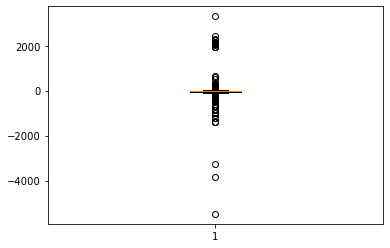

In [30]:
plt.boxplot(grand_df['Amount'])

In [31]:
grand_df.drop('Date', axis=1, inplace=True)

In [32]:
grand_df.columns

Index(['Purchase Date', 'Content', 'Amount', 'Category', 'Payment_Method', 'Purchase Time', 'Verification Date'], dtype='object')

In [36]:
test_df = grand_df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Content', 'Amount', 'Verification Date', \
                   'Category']].copy()

In [37]:
test_df.columns == grand_df.columns

array([ True, False, False, False, False, False, False])

In [38]:
len(test_df.columns) == len(grand_df.columns)

True

In [39]:
grand_df = test_df.copy()

In [40]:
grand_df.head(1)

Purchase Date Purchase Time         Payment_Method                      Content  Amount Verification Date   Category
0    2020-04-29      12:47:00  POS PURCHASE with PIN  GIANT 0774 ARLINGTON VA 001   -5.11        2020-04-29  Groceries

In [41]:
grand_df[grand_df['Category'] == 'Default']['Content'].value_counts()

VENMO/PAYMENTWALTER COLEMAN Default                                 26
ROBINHOOD/FundsWalter Coleman Default                                6
BRONSON OF ARLINGTON ARLINGTON VA000026                              3
FUNDRISE GROWTH/2025840550WALTER COLEMAN                             3
WEBULL FINANCIAL/ACHWALTER COLEMAN                                   3
Mobile Check Deposit Default                                         3
FUNDRISE/2025840550WALTER COLEMAN                                    3
SQ *LAS TRANCAS AUSTIN TX 778273                                     2
CVS/PHARMACY #02 02142- ALRINGTON VA999999                           2
WE THE PIZZA ARLINGTON VA 793031                                     2
A-PLUS #74 STERLING VA 127315                                        2
708 BOWLERO ARLINGTON 8 ARLINGTON VA501997                           2
CORADOS RESTAURANT WASHINGTON DC090207                               2
BORURAMEN ARLINGTON VA 794503                                        1
WONDEE

In [ ]:
grand_df.loc[grand_df['Content'].str.contains("PIZZA",na=False),'Category'] = 'Dining Out'
grand_df.loc[grand_df['Content'].str.contains("CROWNE PLAZA",na=False),'Category'] = 'Dining Out'
grand_df.loc[grand_df['Content'].str.contains("CROWNE PLAZA",na=False),'Category'] = 'Dining Out'

In [ ]:
retlen(x.split(' '))

In [42]:
grand_df['Content_Word_Length'] = grand_df['Content'].apply(lambda x: len(x.split(' ')))

In [43]:
grand_df['Content_Word_Length']

0       5
1       7
2       7
3       5
4       5
5       5
6       5
7       5
8       5
9       6
10      5
11      3
12      4
13      6
14      5
15      5
16      5
17      5
18      5
19      3
20      3
21      6
22      5
23      5
24      5
25      5
26      5
27      5
28      6
29      5
30      5
31      5
32      5
33      6
34      5
35      4
36      4
37      5
38      5
39      5
40      3
41      5
42      7
43      8
44      5
45      5
46      2
47      3
48      6
49      4
50      7
51      6
52      5
53      5
54      6
55      4
56      5
57      6
58      4
59      4
60      3
61      5
62      3
63      6
64      3
65      5
66      8
67      5
68      8
69      6
70      5
71      5
72      6
73      5
74      3
75      3
76      3
77      3
78      5
79      8
80      3
81      3
82      6
83      7
84      7
85      8
86      5
87      5
88      6
89      5
90      4
91      8
92      8
93      6
94      6
95      5
96      6
97      8
98      8
99      6


In [44]:
grand_df['Content_Word_Length'].min()

2

In [45]:
grand_df['Content_Word_Length'].value_counts()

5     235
6     216
3     103
8      71
7      71
4      50
10      4
9       4
2       3
Name: Content_Word_Length, dtype: int64

In [46]:
grand_df['First_Word'] = grand_df['Content'].apply(lambda x: x.split(' ')[0])
grand_df['Last_Word'] = grand_df['Content'].apply(lambda x: x.split(' ')[-1])

In [48]:
def middle_words(x):
    if(len(x) > 2):
        return x[1:-1]
    else:
        return "N/A"

In [49]:
grand_df['Middle_Words'] = grand_df['Content'].apply(lambda x: middle_words(x.split(' ')))

In [47]:
grand_df

Purchase Date Purchase Time         Payment_Method                                                              Content   Amount Verification Date                  Category  Content_Word_Length                 First_Word Last_Word
0      2020-04-29      12:47:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001    -5.11        2020-04-29                 Groceries                    5                      GIANT       001
1      2020-04-29      02:32:00                  Other  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00        2020-04-29                     Extra                    7           Person-to-Person          
2      2020-04-28      22:44:00   POS PURCHASE Non-PIN                       PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99        2020-04-29             Entertainment                    7                  PP*GOOGLE          
3      2020-04-28      13:17:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001    -5.11        2020-04-28                 Groceries                    5                      GIANT       001
4      2020-04-26      22:23:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA INB600   -21.23        2020-04-27                Dining Out                    5                       UBER    INB600
5      2020-04-26      22:23:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA INB500    -3.70        2020-04-27                Dining Out                    5                       UBER    INB500
6      2020-04-24      15:16:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001   -47.51        2020-04-24                 Groceries                    5                      GIANT       001
7      2020-04-23      03:43:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN1610   -17.49        2020-04-23                Dining Out                    5                       UBER    IN1610
8      2020-04-23      03:43:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN8900    -2.09        2020-04-23                Dining Out                    5                       UBER    IN8900
9      2020-04-22      19:30:00   POS PURCHASE Non-PIN                        VTG*Emmaus Family Couns 703-7292822 VA000000   -125.00        2020-04-23                   Medical                    6                 VTG*Emmaus          
10     2020-04-22      11:10:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001   -39.52        2020-04-22                 Groceries                    5                      GIANT       001
11     2020-04-22      00:00:00                  Other                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62        2020-04-22             Student Loans                    3     FEDLOANSERVICING/STDNT   COLEMAN
12     2020-04-22      00:00:00                  Other                                    USAA.COM PAY EXT/PCWALTER COLEMAN  -243.63        2020-04-22            USAA Insurance                    4                   USAA.COM   COLEMAN
13     2020-04-22      00:00:00                  Other                            Pillar DC/Pillar DCPILLAR CHURCH OF WASHI  -109.81        2020-04-22                     Tithe                    6                     Pillar     WASHI
14     2020-04-21      22:45:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN1090    -2.10        2020-04-22                Dining Out                    5                       UBER    IN1090
15     2020-04-21      22:45:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN8800   -20.99        2020-04-22                Dining Out                    5                       UBER    IN8800
16     20

In [50]:
grand_df

Purchase Date Purchase Time         Payment_Method                                                              Content   Amount Verification Date                  Category  Content_Word_Length                 First_Word Last_Word                                                         Middle_Words
0      2020-04-29      12:47:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001    -5.11        2020-04-29                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
1      2020-04-29      02:32:00                  Other  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00        2020-04-29                     Extra                    7           Person-to-Person                        [TransferPOP*Margaret, Coleman, Visa, Direct, VAPOPMON]
2      2020-04-28      22:44:00   POS PURCHASE Non-PIN                       PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99        2020-04-29             Entertainment                    7                  PP*GOOGLE                                      [A, MEDIUM, CORP, 402-935-7733, CAINC000]
3      2020-04-28      13:17:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001    -5.11        2020-04-28                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
4      2020-04-26      22:23:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA INB600   -21.23        2020-04-27                Dining Out                    5                       UBER    INB600                                            [EATS, HELP.UBER.COM, CA]
5      2020-04-26      22:23:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA INB500    -3.70        2020-04-27                Dining Out                    5                       UBER    INB500                                            [EATS, HELP.UBER.COM, CA]
6      2020-04-24      15:16:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001   -47.51        2020-04-24                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
7      2020-04-23      03:43:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN1610   -17.49        2020-04-23                Dining Out                    5                       UBER    IN1610                                            [EATS, HELP.UBER.COM, CA]
8      2020-04-23      03:43:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN8900    -2.09        2020-04-23                Dining Out                    5                       UBER    IN8900                                            [EATS, HELP.UBER.COM, CA]
9      2020-04-22      19:30:00   POS PURCHASE Non-PIN                        VTG*Emmaus Family Couns 703-7292822 VA000000   -125.00        2020-04-23                   Medical                    6                 VTG*Emmaus                                         [Family, Couns, 703-7292822, VA000000]
10     2020-04-22      11:10:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001   -39.52        2020-04-22                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
11     2020-04-22      00:00:00                  Other                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62        2020-04-22             Student Loans                    3     FEDLOANSERVICING/STDNT   COLEMAN                                                         [LOANWALTER]
12     2020-04-22      00:00:00                  Oth

In [52]:
grand_df[grand_df['Category'] == 'Default']['First_Word'].value_counts()

VENMO/PAYMENTWALTER          27
SQ                           20
PAYPAL                       15
TST*                          7
ROBINHOOD/FundsWalter         6
POS                           5
FUNDRISE                      4
UNITED                        4
WEBULL                        3
WE                            3
708                           3
USA*VEND                      3
BRONSON                       3
Mobile                        3
7-ELEVEN                      3
THE                           3
FUNDRISE/2025840550WALTER     3
GoFndMe*                      2
CORADOS                       2
A-PLUS                        2
CVS/PHARMACY                  2
JOE                           2
MTA*METROCARD                 2
NNT                           2
ATM                           2
TAQUERIA                      2
EL                            2
MAGOOSH                       2
TAL                           1
FANATICOS                     1
VA                            1
Peabody 

In [53]:
grand_df[grand_df['Category'] == 'Default']['Last_Word'].value_counts()

           117
Default     38
COLEMAN     11
778273       5
793031       3
Coleman      2
127315       2
J            2
IN1070       2
543202       1
COLEMA       1
119210       1
754736       1
IN6600       1
000007       1
IN8900       1
IN1200       1
047865       1
IN0800       1
IN9000       1
INA500       1
900708       1
399971       1
R0HMXQ       1
IN8700       1
Square       1
IN7300       1
00MF31       1
794503       1
020632       1
027220       1
WALTER       1
IN0300       1
763960       1
783444       1
INC900       1
504325       1
00MP57       1
INP700       1
242647       1
IN1090       1
585831       1
132571       1
000148       1
VA           1
010966       1
IN7200       1
INC100       1
IN4400       1
IN0700       1
930204       1
0000JY       1
499850       1
264700       1
000002       1
925647       1
INB900       1
027750       1
00M6LQ       1
Name: Last_Word, dtype: int64

In [54]:
grand_df[grand_df['Category'] == 'Default']['Middle_Words']

16                                    [8008456167, 800-845-6167, NCIN7200]
33                                   [TREAS, 310/TAX, REFCOLEMAN,, WALTER]
36                                                        [Check, Deposit]
42                           [*IDIDOS, SOCIAL, HOUSE, Arlington, VAINB900]
46                                                                     N/A
47                                               [GROWTH/2025840550WALTER]
51                                     [*EDX, INC, 402-935-7733, MAINC000]
52                                             [Real, Est/WEB, PMTSWalter]
55                                               [Amzn.com/bill, WAIN0800]
57                                           [*SOL, SCHOTT, Arlington, VA]
58                                       [DEPT, TAXATION/WITHDRAWALWALTER]
60                                                               [COLEMAN]
69                                           [*SOL, SCHOTT, Arlington, VA]
74                       

In [ ]:
# defaults with positive amounts
# defaults with 00:00:00 times

{'whiskers': [<matplotlib.lines.Line2D at 0x1be04078d30>,
 'caps': [<matplotlib.lines.Line2D at 0x1be040ef430>,
 'boxes': [<matplotlib.lines.Line2D at 0x1be040789d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1be040efaf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1be040efdf0>],
 'means': []}

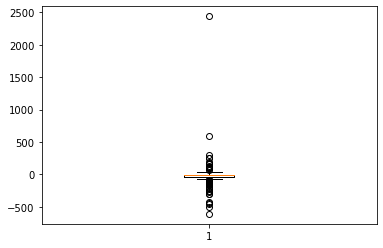

In [55]:
plt.boxplot(grand_df[grand_df['Category'] == 'Default']['Amount'])

In [56]:
grand_df['Category'].value_counts()

Default                     232
Groceries                   145
Dining Out                  123
Tolls/Uber/Metro/Parking     46
Medical                      26
Venmo Extra                  23
Utilities                    21
Pay Check                    19
Entertainment                17
Gas                          15
Tithe                        15
Student Loans                13
Gym                          12
Misc                         12
Extra                        12
Rent                         10
USAA Insurance               10
Phone                         6
Name: Category, dtype: int64

In [57]:
defaults = grand_df[grand_df['Category'] == 'Default']

In [58]:
defaults[defaults['Amount'] > 0]

Purchase Date Purchase Time Payment_Method                                                          Content   Amount Verification Date Category  Content_Word_Length                 First_Word Last_Word                                                         Middle_Words
33     2020-04-17      00:00:00          Other                           IRS TREAS 310/TAX REFCOLEMAN, WALTER J  2439.00        2020-04-17  Default                    6                        IRS         J                                [TREAS, 310/TAX, REFCOLEMAN,, WALTER]
36     2020-04-16      00:00:00          Other                                     Mobile Check Deposit Default   126.00        2020-04-16  Default                    4                     Mobile   Default                                                     [Check, Deposit]
46     2020-04-10      00:00:00          Other                                FUNDRISE/2025840550WALTER COLEMAN     1.53        2020-04-10  Default                    2  FUNDRISE/2025840550WALTER   COLEMAN                                                                  N/A
47     2020-04-10      00:00:00          Other                         FUNDRISE GROWTH/2025840550WALTER COLEMAN     0.43        2020-04-10  Default                    3                   FUNDRISE   COLEMAN                                            [GROWTH/2025840550WALTER]
122    2020-08-21      00:00:00          Other                             ACCENTURE FEDERA/EFTWALTER J COLEMAN   100.00        2020-08-21  Default                    4                  ACCENTURE   COLEMAN                                                [FEDERA/EFTWALTER, J]
241    2020-12-10      00:00:00          Other                                     Mobile Check Deposit Default   120.08        2020-12-10  Default                    4                     Mobile   Default                                                     [Check, Deposit]
277    2021-01-05      00:00:00          Other                                     Mobile Check Deposit Default   175.00        2021-01-05  Default                    4                     Mobile   Default                                                     [Check, Deposit]
278    2021-01-04      00:00:00          Other  Federal Benefit Payment/XXTAXEIP2IRS TREAS 310COLEMAN, WALTER J   600.00        2021-01-04  Default                    7                    Federal         J          [Benefit, Payment/XXTAXEIP2IRS, TREAS, 310COLEMAN,, WALTER]
391    2020-07-10      00:00:00          Other                                FUNDRISE/2025840550WALTER COLEMAN     3.25        2020-07-10  Default                    2  FUNDRISE/2025840550WALTER   COLEMAN                                                                  N/A
399    2020-07-06      00:00:00          Other                               WEBULL FINANCIAL/ACHWALTER COLEMAN    25.99        2020-07-06  Default                    3                     WEBULL   COLEMAN                                                [FINANCIAL/ACHWALTER]
405    2020-07-03      00:00:00          Other                        FUNDRISE BALANCE/2025840550WALTER COLEMAN    97.00        2020-07-03  Default                    3                   FUNDRISE   COLEMAN                                           [BALANCE/2025840550WALTER]
406    2020-07-03      00:00:00          Other                         FUNDRISE GROWTH/2025840550WALTER COLEMAN    97.50        2020-07-03  Default                    3                   FUNDRISE   COLEMAN                                            [GROWTH/2025840550WALTER]
407    2020-07-03      00:00:00          Other                         FUNDRISE GROWTH/2025840550WALTER COLEMAN    98.10        2020-07-03  Default                    3                   FUNDRISE   COLEMAN                                            [GROWTH/2025840550WALTER]
408    2020-07-02      00:00:00          Other                                FUNDRISE/2025840550WALTER COLEMAN   194.60        2020-07-02  Default       

In [61]:
#set positive defaults to Misc
grand_df.loc[(grand_df['Category'] == 'Default') & (grand_df['Amount'] > 0), 'Category'] = 'Extra'

In [ ]:
grand_df.loc[grand_df[], 'Category'] = 'Extra'

In [63]:
len(defaults[defaults['Amount'] < -45])

43

In [65]:
defaults[defaults['Amount'] < -35]

Purchase Date Purchase Time         Payment_Method                                                        Content  Amount Verification Date Category  Content_Word_Length             First_Word Last_Word                                                     Middle_Words
51     2020-04-09      03:45:00   POS PURCHASE Non-PIN                         PAYPAL *EDX INC 402-935-7733 MAINC000  -255.00        2020-04-10  Default                    6                 PAYPAL                                        [*EDX, INC, 402-935-7733, MAINC000]
58     2020-04-07      00:00:00                  Other                       VA DEPT TAXATION/WITHDRAWALWALTER COLEMA -459.00        2020-04-07  Default                    4                     VA    COLEMA                                [DEPT, TAXATION/WITHDRAWALWALTER]
76     2020-04-02      00:00:00                  VENMO                            VENMO/PAYMENTWALTER COLEMAN Default -430.00        2020-04-02  Default                    3    VENMO/PAYMENTWALTER   Default                                                        [COLEMAN]
79     2020-08-31      07:20:00   POS PURCHASE Non-PIN                  GoFndMe* Help Dace get Redwood City CAINA500  -277.00        2020-08-31  Default                    8               GoFndMe*                                 [Help, Dace, get, Redwood, City, CAINA500]
82     2020-08-30      23:15:00   POS PURCHASE Non-PIN                 PAYPAL *MICROSOFT STORE 402-935-7733 WAINP700   -69.99        2020-08-31  Default                    6                 PAYPAL                                [*MICROSOFT, STORE, 402-935-7733, WAINP700]
84     2020-08-30      23:00:00   POS PURCHASE Non-PIN                      CELEBRATIONS BY RUPA VI ASHBURN VAINC700  -111.91        2020-08-31  Default                    7           CELEBRATIONS                                          [BY, RUPA, VI, ASHBURN, VAINC700]
88     2020-08-30      08:39:00   POS PURCHASE Non-PIN                         PAYPAL *EDX INC 402-935-7733 MAIN7400  -255.00        2020-08-31  Default                    6                 PAYPAL                                        [*EDX, INC, 402-935-7733, MAIN7400]
111    2020-08-22      17:52:00   POS PURCHASE Non-PIN                  PRICELN*DAYS INN BY WY 800-774-2354 CTIN8700  -186.04        2020-08-24  Default                    7           PRICELN*DAYS                                      [INN, BY, WY, 800-774-2354, CTIN8700]
133    2020-08-18      14:05:00   POS PURCHASE Non-PIN                    PAYPAL *AIRBNB HMX5BDZ 4029357733 CAIN7500  -139.22        2020-08-19  Default                    6                 PAYPAL                                   [*AIRBNB, HMX5BDZ, 4029357733, CAIN7500]
141    2020-08-12      13:36:00   POS PURCHASE Non-PIN                    UNITED AIR 01623192326 PAYPAL COM TXIN9200  -168.20        2020-08-12  Default                    7                 UNITED                                  [AIR, 01623192326, PAYPAL, COM, TXIN9200]
174    2020-12-30      10:02:00  POS PURCHASE with PIN                                     MIDAS. ARLINGTON VA 399971 -608.69        2020-12-30  Default                    4                 MIDAS.    399971                                                  [ARLINGTON, VA]
176    2020-12-29      12:01:00                  Other  ATM WITHDRAWALWILLYS BARBE- 3219 COLUMBIA ARLINGTON VAL48155   -43.50        2020-12-29  Default                    8                    ATM            [WITHDRAWALWILLYS, BARBE-, 3219, COLUMBIA, ARLINGTON, VAL48155]
178    2020-12-29      00:08:00   POS PURCHASE Non-PIN                                 SK EYECARE ARLINGTON VA 499850  -49.00        2020-12-30  Default                    5                     SK    499850                                         [EYECARE, ARLINGTON, VA]
185    2020-12-28      00:00:00                  VENMO                            VENMO/PAYMENTWALTER COLEMAN Default  -38.00        2020-12-28  Default                    3    VENMO/PAYMENTWALTER

In [67]:
# 
grand_df.loc[grand_df['Content'].str.contains("Dace",na=False),'Category'] = 'Tithe'

In [73]:
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
grand_df[(np.abs(stats.zscore(grand_df['Amount'])) < 3).all(axis)]

AttributeError: module 'stat' has no attribute 'zscore'

In [74]:
len(defaults[defaults['Amount'] < -35])

58

In [75]:
len(defaults[defaults['Amount'] < -50])

40

In [76]:
len(defaults[defaults['Amount'] < -90])

29

In [77]:
defaults[defaults['Amount'] < -90]

Purchase Date Purchase Time         Payment_Method                                          Content  Amount Verification Date Category  Content_Word_Length             First_Word Last_Word                                  Middle_Words
51     2020-04-09      03:45:00   POS PURCHASE Non-PIN           PAYPAL *EDX INC 402-935-7733 MAINC000  -255.00        2020-04-10  Default                    6                 PAYPAL                     [*EDX, INC, 402-935-7733, MAINC000]
58     2020-04-07      00:00:00                  Other         VA DEPT TAXATION/WITHDRAWALWALTER COLEMA -459.00        2020-04-07  Default                    4                     VA    COLEMA             [DEPT, TAXATION/WITHDRAWALWALTER]
76     2020-04-02      00:00:00                  VENMO              VENMO/PAYMENTWALTER COLEMAN Default -430.00        2020-04-02  Default                    3    VENMO/PAYMENTWALTER   Default                                     [COLEMAN]
79     2020-08-31      07:20:00   POS PURCHASE Non-PIN    GoFndMe* Help Dace get Redwood City CAINA500  -277.00        2020-08-31  Default                    8               GoFndMe*              [Help, Dace, get, Redwood, City, CAINA500]
84     2020-08-30      23:00:00   POS PURCHASE Non-PIN        CELEBRATIONS BY RUPA VI ASHBURN VAINC700  -111.91        2020-08-31  Default                    7           CELEBRATIONS                       [BY, RUPA, VI, ASHBURN, VAINC700]
88     2020-08-30      08:39:00   POS PURCHASE Non-PIN           PAYPAL *EDX INC 402-935-7733 MAIN7400  -255.00        2020-08-31  Default                    6                 PAYPAL                     [*EDX, INC, 402-935-7733, MAIN7400]
111    2020-08-22      17:52:00   POS PURCHASE Non-PIN    PRICELN*DAYS INN BY WY 800-774-2354 CTIN8700  -186.04        2020-08-24  Default                    7           PRICELN*DAYS                   [INN, BY, WY, 800-774-2354, CTIN8700]
133    2020-08-18      14:05:00   POS PURCHASE Non-PIN      PAYPAL *AIRBNB HMX5BDZ 4029357733 CAIN7500  -139.22        2020-08-19  Default                    6                 PAYPAL                [*AIRBNB, HMX5BDZ, 4029357733, CAIN7500]
141    2020-08-12      13:36:00   POS PURCHASE Non-PIN      UNITED AIR 01623192326 PAYPAL COM TXIN9200  -168.20        2020-08-12  Default                    7                 UNITED               [AIR, 01623192326, PAYPAL, COM, TXIN9200]
174    2020-12-30      10:02:00  POS PURCHASE with PIN                       MIDAS. ARLINGTON VA 399971 -608.69        2020-12-30  Default                    4                 MIDAS.    399971                               [ARLINGTON, VA]
230    2020-12-14      06:33:00   POS PURCHASE Non-PIN     senseofplacecafe.com 972-543190919 CAIN7900  -159.69        2020-12-14  Default                    4   senseofplacecafe.com                               [972-543190919, CAIN7900]
232    2020-12-14      00:00:00                  Other        Washington Gas L/8449274427Walter Coleman -101.34        2020-12-14  Default                    4             Washington   Coleman                     [Gas, L/8449274427Walter]
267    2021-01-29      00:00:00                  Other          Security deposit TO: DDXXXX5941 Default -442.82        2021-01-29  Default                    5               Security   Default                    [deposit, TO:, DDXXXX5941]
338    2020-01-07      05:23:00   POS PURCHASE Non-PIN      PAYPAL *AIRBNB HMR2T94 4029357733 CAIN1410  -144.13        2021-01-08  Default                    6                 PAYPAL                [*AIRBNB, HMR2T94, 4029357733, CAIN1410]
340    2020-01-05      15:11:00   POS PURCHASE Non-PIN        UNITED 01623319517 800-932-2732 TXINC100  -134.60        2021-01-07  Default                    5                 UNITED                   [01623319517, 800-932-2732, TXINC100]
355    2020-07-25      11:09:00   POS PURCHASE Non-PIN      PSI SERVICES LLC USD 818-847-6180 CAINA500  -100.00        2020-07-27  Default                    7                    P

In [85]:
type(defaults['Purchase Time'][51])

datetime.time

In [92]:
import datetime as dt

In [96]:
defaults[defaults['Purchase Time'] == dt.time(0,0,0)]

Purchase Date Purchase Time Payment_Method                                                    Content  Amount Verification Date Category  Content_Word_Length             First_Word Last_Word                                                Middle_Words
52     2020-04-09      00:00:00          Other                    Peabody Real Est/WEB PMTSWalter Coleman  -25.00        2020-04-09  Default                    5                Peabody   Coleman                                 [Real, Est/WEB, PMTSWalter]
58     2020-04-07      00:00:00          Other                   VA DEPT TAXATION/WITHDRAWALWALTER COLEMA -459.00        2020-04-07  Default                    4                     VA    COLEMA                           [DEPT, TAXATION/WITHDRAWALWALTER]
60     2020-04-07      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default   -5.80        2020-04-07  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
74     2020-04-02      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default   -4.00        2020-04-02  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
75     2020-04-02      00:00:00          VENMO                      VENMO/PAYMENTWALTER COLEMAN*1 Default   -4.00        2020-04-02  Default                    3    VENMO/PAYMENTWALTER   Default                                                 [COLEMAN*1]
76     2020-04-02      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default -430.00        2020-04-02  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
161    2020-08-03      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -25.00        2020-08-03  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
179    2020-12-29      00:00:00          Other  ATM WD FEE L48155WILLYS BARBE- 3219 COLUMBIA ARLINGTON VA   -3.00        2020-12-29  Default                    9                    ATM        VA  [WD, FEE, L48155WILLYS, BARBE-, 3219, COLUMBIA, ARLINGTON]
185    2020-12-28      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -38.00        2020-12-28  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
187    2020-12-28      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -40.00        2020-12-28  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
195    2020-12-23      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -14.00        2020-12-23  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
207    2020-12-21      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -24.66        2020-12-21  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
208    2020-12-21      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -53.18        2020-12-21  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
224    2020-12-15      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -48.00        2020-12-15  Default                    3    VENMO/PAYMENTWALTER   Default                                                   [COLEMAN]
225    2020-12-15      00:00:00          VENMO                        VENMO/PAYMENTWALTER COLEMAN Default  -24.07        2020-12-15  Default                    3    VENMO/PAYMENTW

In [109]:
defaults[defaults['Purchase Time'] == dt.time(0,0,0)]['First_Word'].value_counts()

VENMO/PAYMENTWALTER      27
ROBINHOOD/FundsWalter     2
ATM                       1
Washington                1
ARLINGTON                 1
WEBULL                    1
VA                        1
ANDREW                    1
Security                  1
Peabody                   1
Name: First_Word, dtype: int64

In [95]:
defaults = grand_df[grand_df['Category'] == 'Default'].copy()

In [102]:
grand_df.loc[232, "Category"] = 'Utilities'

In [103]:
grand_df.loc[378, 'Category'] = 'Tithe'

In [106]:
print(print(grand_df[grand_df['Category'] == 'Pay Check']['Amount'].sum()))
print(print(grand_df[grand_df['Category'] == 'Tithe']['Amount'].sum()))
# print(print(grand_df[grand_df['Category'] == 'Paycheck']['Amount']))

41174.93
None
-6551.7300000000005
None


In [108]:
x = grand_df[grand_df['Amount'] > 0]['Amount'].sum()
y = grand_df[grand_df['Category'] == 'Tithe']['Amount'].sum() * -1
print(y/x)

0.1291087875038353


In [97]:
grand_df.drop([267], inplace=True)

In [111]:
grand_df.loc[(grand_df['Purchase Time'] == dt.time(0,0,0)) & (grand_df['Category'] == 'Default') & \
             (grand_df['First_Word'] != 'VENMO/PAYMENTWALTER'), 'Category'] = 'Misc'

In [112]:
grand_df[grand_df['Category'] == 'Default']['First_Word'].value_counts()

VENMO/PAYMENTWALTER     27
SQ                      20
PAYPAL                  15
TST*                     7
UNITED                   4
BRONSON                  3
USA*VEND                 3
708                      3
7-ELEVEN                 3
WE                       3
THE                      3
JOE                      2
A-PLUS                   2
CORADOS                  2
TAQUERIA                 2
NNT                      2
MAGOOSH                  2
EL                       2
POS                      2
CVS/PHARMACY             2
MTA*METROCARD            2
CO                       1
UberAT_EATS              1
PILLAR                   1
Amazon.com*MV1QM0V80     1
FANATICOS                1
TAL                      1
RAPPAHANNOCK             1
NORTH                    1
PSI                      1
TAKOHACHI                1
CITY                     1
SY8                      1
UberEATS                 1
DEL                      1
CASINO                   1
senseofplacecafe.com     1
P

In [113]:
grand_df[grand_df['First_Word'] == 'SQ']

Purchase Date Purchase Time        Payment_Method                                          Content  Amount Verification Date    Category  Content_Word_Length First_Word Last_Word                                        Middle_Words
42     2020-04-12      18:30:00  POS PURCHASE Non-PIN      SQ *IDIDOS SOCIAL HOUSE Arlington VAINB900    -5.28        2020-04-13     Default                    7         SQ                 [*IDIDOS, SOCIAL, HOUSE, Arlington, VAINB900]
57     2020-04-07      20:00:00  POS PURCHASE Non-PIN               SQ *SOL SCHOTT Arlington VA IN1070  -14.52        2020-04-08     Default                    6         SQ    IN1070                       [*SOL, SCHOTT, Arlington, VA]
69     2020-04-03      00:50:00  POS PURCHASE Non-PIN               SQ *SOL SCHOTT Arlington VA INC900  -14.52        2020-04-06     Default                    6         SQ    INC900                       [*SOL, SCHOTT, Arlington, VA]
91     2020-08-28      00:50:00  POS PURCHASE Non-PIN  SQ *NAZRET ETHIOPIA RES BAILEYS CROSS VAIN7400   -20.34        2020-08-31  Dining Out                    8         SQ            [*NAZRET, ETHIOPIA, RES, BAILEYS, CROSS, VAIN7400]
105    2020-08-23      17:30:00  POS PURCHASE Non-PIN               SQ *HOLEY CREAM New York NY INB900   -5.23        2020-08-24     Default                    7         SQ    INB900                      [*HOLEY, CREAM, New, York, NY]
107    2020-08-23      13:58:00  POS PURCHASE Non-PIN                   SQ *CHALAIT New York NY INC100   -5.36        2020-08-24     Default                    6         SQ    INC100                           [*CHALAIT, New, York, NY]
110    2020-08-22      22:49:00  POS PURCHASE Non-PIN           SQ *VAN LEEUWEN ICE NEW YORK NYINC600   -11.53        2020-08-24     Default                    8         SQ                     [*VAN, LEEUWEN, ICE, NEW, YORK, NYINC600]
252    2020-12-06      10:50:00  POS PURCHASE Non-PIN         SQ *COMET PING PONG WASHINGTON DCIN7400   -21.78        2020-12-07     Default                    7         SQ                    [*COMET, PING, PONG, WASHINGTON, DCIN7400]
298    2020-01-24      02:56:00  POS PURCHASE Non-PIN                  SQ *SPICY BOYS AUSTIN TX 778273  -10.65        2021-01-25     Default                    6         SQ    778273                          [*SPICY, BOYS, AUSTIN, TX]
299    2020-01-24      01:27:00  POS PURCHASE Non-PIN              SQ *SAN JAC SALOON AUSTIN TX 778273   -7.20        2021-01-25     Default                    7         SQ    778273                     [*SAN, JAC, SALOON, AUSTIN, TX]
300    2020-01-24      00:13:00  POS PURCHASE Non-PIN                 SQ *LAS TRANCAS AUSTIN TX 778273   -8.12        2021-01-25     Default                    6         SQ    778273                         [*LAS, TRANCAS, AUSTIN, TX]
301    2020-01-23      23:52:00  POS PURCHASE Non-PIN                 SQ *LAS TRANCAS AUSTIN TX 778273   -7.80        2021-01-25     Default                    6         SQ    778273                         [*LAS, TRANCAS, AUSTIN, TX]
312    2020-01-22      13:18:00  POS PURCHASE Non-PIN            SQ *ATX MASTER DONUT AUSTIN TX778273    -5.96        2021-01-22     Default                    7         SQ                       [*ATX, MASTER, DONUT, AUSTIN, TX778273]
330    2020-01-12      00:39:00  POS PURCHASE Non-PIN      SQ *THREE WHISTLES (EAT ARLINGTON VA778273    -7.60        2021-01-12     Default                    7         SQ                 [*THREE, WHISTLES, (EAT, ARLINGTON, VA778273]
345    2020-01-03      02:28:00  POS PURCHASE Non-PIN          SQ *CLARENDON POPUP ARLINGTON VA778273   -15.18        2021-01-04     Default                    6         SQ                      [*CLARENDON, POPUP, ARLINGTON, VA778273]
457    2020-06-11      23:17:00  POS PURCHASE Non-PIN       SQ *MERCADITO RAMOS VA Arlington VAINC900    -4.85        2020-06-12     Default                    7         SQ                  [*MERCADITO, RAMOS, VA, Arlington, VAINC900]
503    20

In [114]:
grand_df.loc[586, 'Category'] = 'Misc'

In [115]:
grand_df.loc[(grand_df['Category'] == 'Default') & (grand_df['First_Word'] == 'SQ'), 'Category'] = 'Dining Out'

In [116]:
grand_df[grand_df['Category'] == 'Default']

Purchase Date Purchase Time         Payment_Method                                                           Content  Amount Verification Date Category  Content_Word_Length            First_Word Last_Word                                                         Middle_Words
16     2020-04-21      01:58:00   POS PURCHASE Non-PIN                     LCA*LABCORP 8008456167 800-845-6167 NCIN7200   -21.82        2020-04-21  Default                    5           LCA*LABCORP                                           [8008456167, 800-845-6167, NCIN7200]
51     2020-04-09      03:45:00   POS PURCHASE Non-PIN                            PAYPAL *EDX INC 402-935-7733 MAINC000  -255.00        2020-04-10  Default                    6                PAYPAL                                            [*EDX, INC, 402-935-7733, MAINC000]
55     2020-04-08      05:41:00   POS PURCHASE Non-PIN                      Amazon.com*HS19X96T3 Amzn.com/bill WAIN0800   -28.08        2020-04-16  Default                    4  Amazon.com*HS19X96T3                                                      [Amzn.com/bill, WAIN0800]
60     2020-04-07      00:00:00                  VENMO                               VENMO/PAYMENTWALTER COLEMAN Default   -5.80        2020-04-07  Default                    3   VENMO/PAYMENTWALTER   Default                                                            [COLEMAN]
74     2020-04-02      00:00:00                  VENMO                               VENMO/PAYMENTWALTER COLEMAN Default   -4.00        2020-04-02  Default                    3   VENMO/PAYMENTWALTER   Default                                                            [COLEMAN]
75     2020-04-02      00:00:00                  VENMO                             VENMO/PAYMENTWALTER COLEMAN*1 Default   -4.00        2020-04-02  Default                    3   VENMO/PAYMENTWALTER   Default                                                          [COLEMAN*1]
76     2020-04-02      00:00:00                  VENMO                               VENMO/PAYMENTWALTER COLEMAN Default -430.00        2020-04-02  Default                    3   VENMO/PAYMENTWALTER   Default                                                            [COLEMAN]
82     2020-08-30      23:15:00   POS PURCHASE Non-PIN                    PAYPAL *MICROSOFT STORE 402-935-7733 WAINP700   -69.99        2020-08-31  Default                    6                PAYPAL                                    [*MICROSOFT, STORE, 402-935-7733, WAINP700]
83     2020-08-30      23:05:00   POS PURCHASE Non-PIN                        BEAR CHASE BREWING COMP BLUEMONT VAIN7200    -8.57        2020-08-31  Default                    7                  BEAR                                     [CHASE, BREWING, COMP, BLUEMONT, VAIN7200]
84     2020-08-30      23:00:00   POS PURCHASE Non-PIN                         CELEBRATIONS BY RUPA VI ASHBURN VAINC700  -111.91        2020-08-31  Default                    7          CELEBRATIONS                                              [BY, RUPA, VI, ASHBURN, VAINC700]
87     2020-08-30      12:42:00  POS PURCHASE with PIN                                PENROSE SQUARE ARLINGTON VA Square  -26.00        2020-08-31  Default                    5               PENROSE    Square                                              [SQUARE, ARLINGTON, VA]
88     2020-08-30      08:39:00   POS PURCHASE Non-PIN                            PAYPAL *EDX INC 402-935-7733 MAIN7400  -255.00        2020-08-31  Default                    6                PAYPAL                                            [*EDX, INC, 402-935-7733, MAIN7400]
89     2020-08-30      08:39:00   POS PURCHASE Non-PIN                             PAYPAL *RUSTAMKO 4029357733 CAIN8000    -5.75        2020-08-31  Default                    5                PAYPAL                                              [*RUSTAMKO, 4029357733, CAIN8000]
104    2020-08-23      20:42:00   POS PURCHASE Non-PIN                                    WONDEE SIAM NEW YORK N

In [117]:
len(grand_df[grand_df['Category'] == 'Default'])

178

In [118]:
grand_df[grand_df['Category'] == 'Default']['Last_Word'].value_counts()

           103
Default     27
793031       3
127315       2
0000JY       1
763960       1
399971       1
R0HMXQ       1
027220       1
IN0700       1
Square       1
930204       1
IN7300       1
020632       1
543202       1
IN9000       1
499850       1
INA500       1
794503       1
000002       1
IN1200       1
925647       1
027750       1
900708       1
264700       1
242647       1
IN1070       1
783444       1
IN0300       1
504325       1
00MP57       1
000148       1
010966       1
00M6LQ       1
IN4400       1
119210       1
754736       1
IN6600       1
IN1090       1
IN8900       1
047865       1
00MF31       1
000007       1
585831       1
INP700       1
132571       1
IN8700       1
Name: Last_Word, dtype: int64

In [119]:
grand_df[grand_df['Category'] == 'Default']['Middle_Words'].value_counts()

[COLEMAN]                                                              26
[OF, ARLINGTON, ARLINGTON, VA000026]                                    3
[ARLINGTON, VA]                                                         3
[THE, PIZZA, ARLINGTON, VA]                                             2
[RESTAURANT, WASHINGTON, DC090207]                                      2
[INC, 510-214-0212, CA]                                                 2
[BOWLERO, ARLINGTON, 8, ARLINGTON, VA501997]                            2
[SQUARE, ARLINGTON, VA]                                                 2
[#02, 02142-, ALRINGTON, VA999999]                                      2
[800-5928996, CA]                                                       2
[#74, STERLING, VA]                                                     2
[MACHINE, NEW, YORK, NYIN2000]                                          1
[UPS, STORE, #0657, ARLINGTON, VA105]                                   1
[STREET, BAR, AUSTIN, TX]             

In [121]:
grand_df

Purchase Date Purchase Time         Payment_Method                                                              Content   Amount Verification Date                  Category  Content_Word_Length                 First_Word Last_Word                                                         Middle_Words
0      2020-04-29      12:47:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001    -5.11        2020-04-29                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
1      2020-04-29      02:32:00                  Other  Person-to-Person TransferPOP*Margaret Coleman Visa Direct VAPOPMON    250.00        2020-04-29                     Extra                    7           Person-to-Person                        [TransferPOP*Margaret, Coleman, Visa, Direct, VAPOPMON]
2      2020-04-28      22:44:00   POS PURCHASE Non-PIN                       PP*GOOGLE A MEDIUM CORP 402-935-7733 CAINC000     -4.99        2020-04-29             Entertainment                    7                  PP*GOOGLE                                      [A, MEDIUM, CORP, 402-935-7733, CAINC000]
3      2020-04-28      13:17:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001    -5.11        2020-04-28                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
4      2020-04-26      22:23:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA INB600   -21.23        2020-04-27                Dining Out                    5                       UBER    INB600                                            [EATS, HELP.UBER.COM, CA]
5      2020-04-26      22:23:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA INB500    -3.70        2020-04-27                Dining Out                    5                       UBER    INB500                                            [EATS, HELP.UBER.COM, CA]
6      2020-04-24      15:16:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001   -47.51        2020-04-24                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
7      2020-04-23      03:43:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN1610   -17.49        2020-04-23                Dining Out                    5                       UBER    IN1610                                            [EATS, HELP.UBER.COM, CA]
8      2020-04-23      03:43:00   POS PURCHASE Non-PIN                                    UBER EATS HELP.UBER.COM CA IN8900    -2.09        2020-04-23                Dining Out                    5                       UBER    IN8900                                            [EATS, HELP.UBER.COM, CA]
9      2020-04-22      19:30:00   POS PURCHASE Non-PIN                        VTG*Emmaus Family Couns 703-7292822 VA000000   -125.00        2020-04-23                   Medical                    6                 VTG*Emmaus                                         [Family, Couns, 703-7292822, VA000000]
10     2020-04-22      11:10:00  POS PURCHASE with PIN                                          GIANT 0774 ARLINGTON VA 001   -39.52        2020-04-22                 Groceries                    5                      GIANT       001                                                [0774, ARLINGTON, VA]
11     2020-04-22      00:00:00                  Other                            FEDLOANSERVICING/STDNT LOANWALTER COLEMAN -1387.62        2020-04-22             Student Loans                    3     FEDLOANSERVICING/STDNT   COLEMAN                                                         [LOANWALTER]
12     2020-04-22      00:00:00                  Oth

In [123]:
grand_df.to_excel('Feb26FinalVersion.xlsx')

In [120]:
grand_df.loc[grand_df['Content'].str.contains("Pizza",na=False),'Category'] = 'Dining Out'
grand_df.loc[grand_df['Content'].str.contains("Amzn",na=False),'Category'] = 'Misc'
grand_df.loc[grand_df['Content'].str.contains("Pollo",na=False),'Category'] = 'Dining Out'

In [ ]:
#Scatter for time of day with the exception of 00:00:00.000 (default)
#
df.plot.scatter(x='hours', y='duration(mins)')

#Scatter for day of week when purchases are made

<BarContainer object of 756 artists>

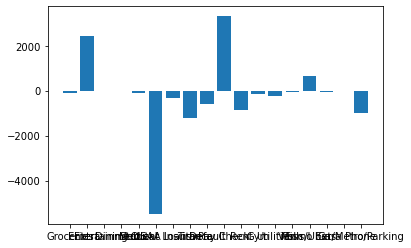

In [100]:
plt.bar(grand_df['Category'], grand_df['Amount'])